<a href="https://colab.research.google.com/github/saigontrade88/Adverserial_Attack/blob/master/Projected_Gradient_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Attacks with Projected Gradient Descent: A Practical Demonstration

Projected Gradient Descent (PGD) is a sophisticated extension of gradient descent tailored for crafting adversarial examples. It introduces a perturbation budget to limit the magnitude of changes made to input data during optimization.

In this tutorial, we would be exploring the fundamentals of crafting adversarial attacks using Projected Gradient Descent (PGD) with a ResNet18 model. Understanding PGD enhances insights into model vulnerabilities and defense strategies in machine learning.

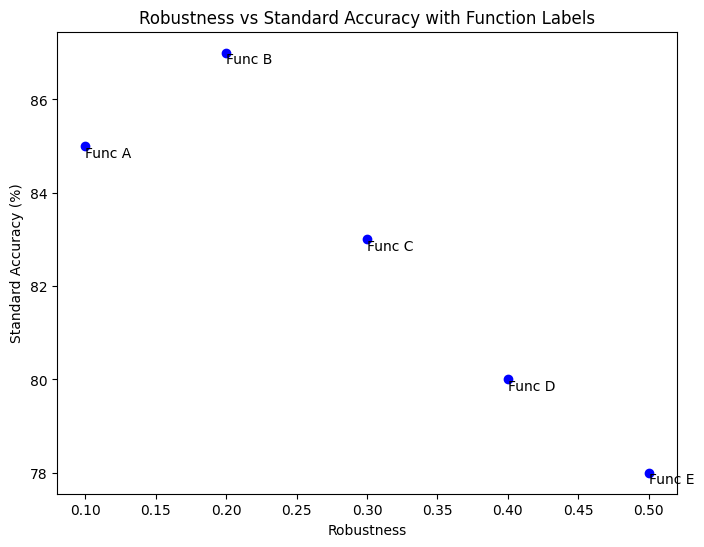

In [7]:
import matplotlib.pyplot as plt

# Sample data (replace these with your actual data)
robustness = [0.1, 0.2, 0.3, 0.4, 0.5]  # Example robustness values
accuracy = [85, 87, 83, 80, 78]          # Corresponding standard accuracy values
functions = ['Func A', 'Func B', 'Func C', 'Func D', 'Func E']  # Function names

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(robustness, accuracy, marker='o', linestyle='', color='b', label='Model Accuracy')

# Add labels for each data point
for i, func in enumerate(functions):
    plt.text(robustness[i], accuracy[i], func, fontsize=10,
             ha='left', va='top')

# Add labels and title
plt.xlabel('Robustness')
plt.ylabel('Standard Accuracy (%)')
plt.title('Robustness vs Standard Accuracy with Function Labels')
# plt.grid(True)

# Save the figure
plt.savefig('robustness_vs_accuracy_with_functions.png', dpi=300, bbox_inches='tight')

# Optionally show the plot (not necessary if just saving the figure)
# plt.show()


## Install Required Libraries
We first install the essential Python libraries required for the tutorial. They include torch, torchvision, and matplotlib.

In [ ]:
!pip install torch torchvision matplotlib

## Importing Necessary Libraries
We now import the essential PyTorch and Matplotlib libraries for building and visualizing adversarial attacks using the powerful Projected Gradient Descent (PGD) algorithm.

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet18

## Download a Sample Image
We'll now download a sample image from the web.

In [ ]:
! wget https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02510455_giant_panda.JPEG -O panda.jpg

--2023-12-26 20:58:21--  https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02510455_giant_panda.JPEG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159221 (155K) [image/jpeg]
Saving to: ‘panda.jpg’

panda.jpg           100%[===================>] 155.49K  --.-KB/s    in 0.02s   

2023-12-26 20:58:22 (10.1 MB/s) - ‘panda.jpg’ saved [159221/159221]



## Visualizing the Downloaded Image
Let's visualize the image downloaded from the web, providing insights into the data used for crafting adversarial attacks.

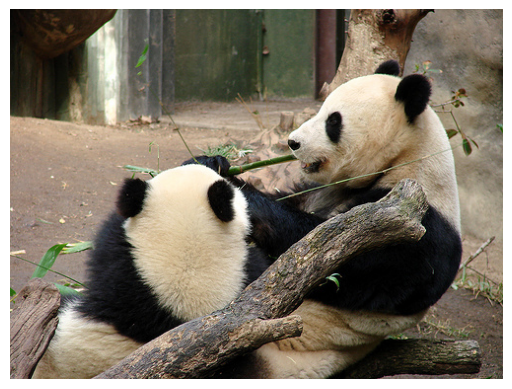

In [ ]:
img = mpimg.imread('panda.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

## Loading a Pretrained ResNet18 Model
For this tutorial, we would be using a pretrained ResNet18 model specifically chosen for its balance between performance and simplicity

In [ ]:
model = resnet18(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Defining a Simple Target Class
In this tutorial, we set a simple target class for generating adversarial examples.

In [ ]:
target_class = 7

##  Loading and Preprocessing an Example Image
We now load and preprocess an example image using torchvision transforms, preparing it for use in crafting adversarial examples.

In [ ]:
# Load and preprocess an example image
image_path = "panda.jpg"
image = Image.open(image_path).convert("RGB")

# Define a transformation to preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Preprocess the image and add a batch dimension
input_image = preprocess(image).unsqueeze(0)

## Performing Projected Gradient Descent (PGD) Attack
Step into the heart of the tutorial—execute the Projected Gradient Descent (PGD) attack algorithm to generate potent adversarial examples and understand its iterative nature.

In [ ]:
# Function to perform PGD attack and get model predictions
def pgd_attack_with_predictions(model, image, target_class, epsilon=0.02, alpha=0.01, num_iter=10):
    """
    Perform a Projected Gradient Descent (PGD) attack on the given image with the specified target class.

    Parameters:
    - model (torch.nn.Module): The pre-trained neural network model.
    - image (torch.Tensor): The input image tensor.
    - target_class (int): The target class index for the adversarial attack.
    - epsilon (float): The maximum perturbation allowed (default is 0.02).
    - alpha (float): The step size for PGD updates (default is 0.01).
    - num_iter (int): The number of iterations for the PGD attack (default is 10).

    Returns:
    - perturbed_image (numpy.ndarray): The perturbed image as a NumPy array.
    - original_predictions (torch.Tensor): Model predictions for the original image.
    - perturbed_predictions (torch.Tensor): Model predictions for the perturbed image.
    """
    image = image.clone().detach().requires_grad_(True)

    for _ in range(num_iter):
        output = model(image)
        loss = -output[0, target_class]
        model.zero_grad()
        loss.backward()

        # PGD update rule
        perturbation = alpha * torch.sign(image.grad)
        image = torch.clamp(image + perturbation, 0, 1).detach().requires_grad_(True)

    perturbed_image = image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

    # Get predictions for both original and perturbed images
    original_predictions = torch.nn.functional.softmax(model(input_image), dim=1)[0]
    perturbed_predictions = torch.nn.functional.softmax(model(image), dim=1)[0]

    return perturbed_image, original_predictions, perturbed_predictions

# Perform PGD attack and get predictions
perturbed_image, original_predictions, perturbed_predictions = pgd_attack_with_predictions(model, input_image, target_class)

## Displaying Predictions for Original and Perturbed Images
Explore the model's predictions for both the original and perturbed images. We can see how the adversarial perturbation influences the classification confidence in real-time.

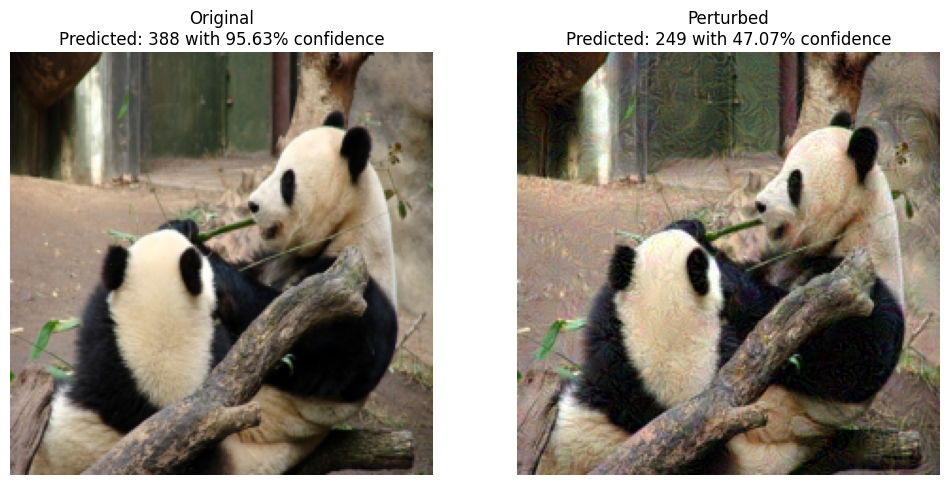

In [ ]:
# Display the original and perturbed images along with predictions
def show_images_with_predictions(original, perturbed, original_predictions, perturbed_predictions, target_class):
    """
    Display the original and perturbed images along with model predictions.

    Parameters:
    - original (numpy.ndarray): Original image as a NumPy array.
    - perturbed (numpy.ndarray): Perturbed image as a NumPy array.
    - original_predictions (torch.Tensor): Model predictions for the original image.
    - perturbed_predictions (torch.Tensor): Model predictions for the perturbed image.
    - target_class (int): The target class index for the adversarial attack.

    Returns:
    None (displays the images and predictions).
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(original)
    axes[0].set_title(f"Original\nPredicted: {original_predictions.argmax()} with {original_predictions.max():.2%} confidence")
    axes[0].axis("off")

    axes[1].imshow(perturbed)
    axes[1].set_title(f"Perturbed\nPredicted: {perturbed_predictions.argmax()} with {perturbed_predictions.max():.2%} confidence")
    axes[1].axis("off")

    plt.show()

# Display the original and perturbed images along with their predictions
original_image_np = input_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
show_images_with_predictions(original_image_np, perturbed_image, original_predictions, perturbed_predictions, target_class)

## Conclusion
In this tutorial, we delved into the world of adversarial attacks, utilizing Projected Gradient Descent (PGD) with a ResNet18 model. By generating adversarial examples, we witnessed firsthand how subtle perturbations can lead to notable changes in model predictions. This exploration not only enhances our understanding of PGD but also underscores the dynamic and sometimes fragile nature of machine learning models in the face of well-crafted adversarial inputs. As we continue to evolve our models, this knowledge becomes instrumental in fortifying them against potential vulnerabilities.




